In [1]:
import torch

from torch.utils.data import DataLoader

from transformers import AutoTokenizer
from datasets import load_dataset
from transformers import AutoModelForCausalLM

from datetime import datetime
from pathlib import Path

from matplotlib import pyplot as plt

from accelerate import Accelerator

# import tensor dataset and data loader
from torch.utils.data import TensorDataset, DataLoader

from icecream import ic

In [2]:
# generate_paths.py generates this data

# There are 63 batches and 24 layers
# We begin my taking the input of the first layer as the start and the output of the last layer as the end
# NOTE: This is the hardest problem since there is the most non-linearity in the model
def read_data():
    starts = []
    ends = []
    for i in range(63):
        start = torch.load(f"../data/paths/2024-01-01_18-43-27/transformer_layer_0_inputs_batch_{i}.pt")
        end = torch.load(f"../data/paths/2024-01-01_18-43-27/transformer_layer_23_outputs_batch_{i}.pt")
        starts.append(start)
        ends.append(end)

    starts = torch.cat(starts)
    ends = torch.cat(ends)
    return starts, ends

starts, ends = read_data()

In [3]:
# 1000 paths, each living in 2048 dimensions, and having 64 steps
ic(starts.shape)
ic(ends.shape)

ic| starts.shape: torch.Size([1000, 64, 2048])
ic| ends.shape: torch.Size([1000, 64, 2048])


torch.Size([1000, 64, 2048])

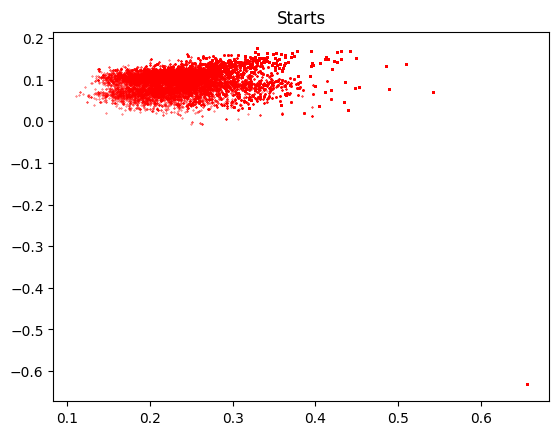

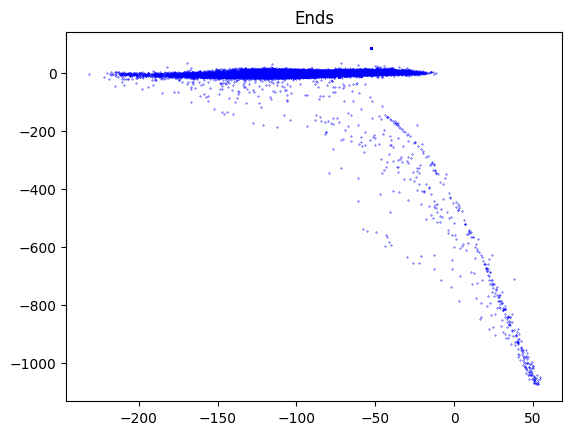

In [4]:
# Project the data using PCA
def project_data(X, n_components=2):
    X = X.reshape(-1, X.shape[-1])
    _, _, V = torch.svd(X)
    X = torch.matmul(X, V[:, :n_components])   
    return X

plt.title("Starts")
plt.scatter(*project_data(starts, n_components=2).detach().cpu().T, s=0.1,c='r')
plt.show()

plt.title("Ends")
plt.scatter(*project_data(ends, n_components=2).detach().cpu().T, s=0.1,c='b')
plt.show()

In [5]:
# Create a linear that maps from the start points to the end points.  
# NOTE: This is not "path aware" since it just works on the points

# This is actually the first term of the Taylor expansion of the function that maps from the start to the end
# So, why not use that first before messing with the neural network?

def linear_map(starts, ends, project_dim=None, verbose=False):
    path_length = starts.shape[1]
    start_points = starts.reshape(-1, starts.shape[2])
    end_points = ends.reshape(-1, ends.shape[2])
    if project_dim is not None:
        start_points = project_data(start_points, project_dim)
        end_points = project_data(end_points, project_dim)
        ic(start_points.shape)
        ic(end_points.shape)
    if verbose:
        ic(torch.linalg.norm(end_points - start_points))
    out = torch.linalg.lstsq(end_points, start_points)
    end_points =  torch.matmul(start_points, out.solution)
    if verbose:
        ic(out.solution.shape)

        # Compute the singular values
        singular_values = torch.linalg.svdvals(out.solution)
        # Compute the condition number
        condition_number = singular_values.max() / singular_values.min()
        # pring the minimum and maximum singular values
        ic(singular_values.min())
        ic(singular_values.max())
        ic(condition_number)

        ic(torch.linalg.norm(end_points - start_points))
    return start_points.reshape(-1, path_length, project_dim), end_points.reshape(-1, path_length, project_dim)

starts_mapped, ends_mapped = linear_map(starts, ends, verbose=True, project_dim=2)

ic(starts_mapped.shape)
ic(ends_mapped.shape)


ic| start_points.shape: torch.Size([64000, 2])
ic| end_points.shape: torch.Size([64000, 2])
ic| torch.linalg.norm(end_points - start_points): tensor(30116.9531, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
ic| out.solution.shape: torch.Size([2, 2])
ic| singular_values.min(): tensor(0.0015, device='cuda:0', grad_fn=<MinBackward1>)
ic| singular_values.max(): tensor(0.0035, device='cuda:0', grad_fn=<MaxBackward1>)
ic| condition_number: tensor(2.2884, device='cuda:0', grad_fn=<DivBackward0>)
ic| torch.linalg.norm(end_points - start_points): tensor(112.7004, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
ic| starts_mapped.shape: torch.Size([1000, 64, 2])
ic| ends_mapped.shape: torch.Size([1000, 64, 2])


torch.Size([1000, 64, 2])

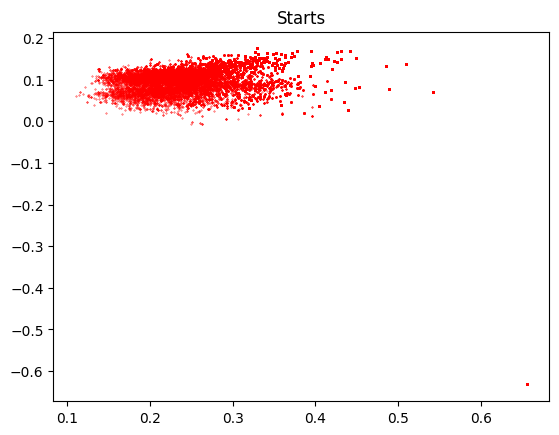

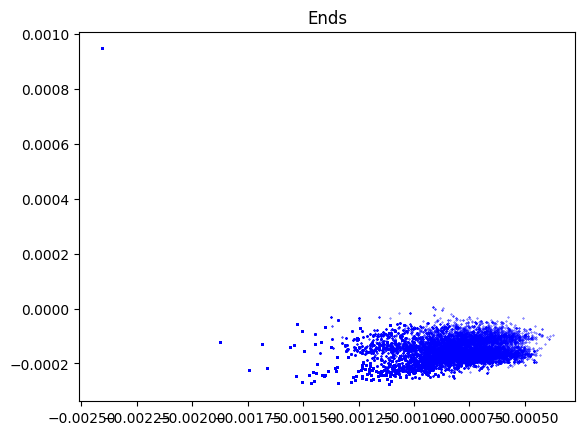

In [6]:
plt.title("Starts")
plt.scatter(*project_data(starts_mapped).detach().cpu().T, s=0.1, c='r')
plt.show()

plt.title("Ends")
plt.scatter(*project_data(ends_mapped).detach().cpu().T, s=0.1, 
            c='b')
plt.show()

In [7]:
dataset = TensorDataset(starts_mapped, ends_mapped)
dataloader = DataLoader(dataset, batch_size=8)

In [8]:
# Run an LSTM on the data
class LSTM(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = torch.nn.LSTM(starts_mapped.shape[-1], ends_mapped.shape[-1], batch_first=True)
        self.linear = torch.nn.Linear(ends_mapped.shape[-1], ends_mapped.shape[-1])

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

model = LSTM()

# Train the model
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

# use the accelerator for distributed training
accelerator = Accelerator()
model, optimizer, dataloader = accelerator.prepare(model, optimizer, dataloader)
torch.cuda.empty_cache()

for epoch in range(1):
    for i, (start, end) in enumerate(dataloader):
        optimizer.zero_grad()
        ic(start.shape)
        ic(end.shape)
        out = model(start)
        loss = loss_fn(out, end)
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print(f'epoch: {epoch}, batch: {i}, loss: {loss}')

            

ic| start.shape: torch.Size([8, 64, 2])
ic| end.shape: torch.Size([8, 64, 2])


OutOfMemoryError: CUDA out of memory. Tried to allocate 15.26 GiB. GPU 0 has a total capacty of 23.65 GiB of which 3.05 GiB is free. Including non-PyTorch memory, this process has 20.57 GiB memory in use. Of the allocated memory 18.24 GiB is allocated by PyTorch, and 724.82 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF